In [2]:
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('leniwce_run2/data.csv', usecols=range(8), encoding='utf-8')

print(df.head(5)) 

   Counter                   Date/time  Latitude  Longitude Image file  \
0        1  2023-05-05 12:54:05.688582  6.682633 -62.045643        day   
1        2  2023-05-05 12:54:43.503046  4.612380 -60.567484        day   
2        3  2023-05-05 12:55:21.735159  2.686210 -59.203338        day   
3        4  2023-05-05 12:55:59.467610  0.736819 -57.828976        day   
4        5  2023-05-05 12:56:37.207741 -1.187191 -56.474213        day   

   Image type Prediction score  sunlight  
0    0.996094              Yes       NaN  
1    0.996094              Yes       NaN  
2    0.996094              Yes       NaN  
3    0.996094              Yes       NaN  
4    0.996094              Yes       NaN  


In [4]:
%pip install orbit
%pip install skyfield

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from skyfield.api import load, wgs84

In [6]:
ts = load.timescale()
t = ts.tt(2023, 5, 5)
t.tdb

2460069.5000000168

In [7]:
n = 25544
# Legacy format: https://celestrak.org/NORAD/elements/gp.php?CATNR=25544&FORMAT=TLE
# url = 'https://celestrak.org/NORAD/elements/gp.php?CATNR={}&FORMAT=TLE'.format(n)
filename = 'tle-CATNR-{}.txt'.format(n)
satellites = load.tle_file(filename)
satellite = satellites[0]
print( satellite )

ISS (ZARYA) catalog #25544 epoch 2023-05-05 12:50:51 UTC


In [8]:
ts = load.timescale()
t = ts.now( )

geocentric = satellite.at(t)
print(geocentric.position.km)

lat, lon = wgs84.latlon_of(geocentric)
print('Latitude:', lat)
print('Longitude:', lon)

[ 3671.16563442 -5717.05266831   -30.04347922]
Latitude: -00deg 11' 09.0"
Longitude: -62deg 52' 15.8"


In [9]:
t = ts.utc(2023, 5, 5)

days = t - satellite.epoch
print('{:.3f} days away from epoch'.format(days))

if abs(days) > 14:
    print("To old")

-0.535 days away from epoch


In [10]:
from datetime import datetime

for i, row in df.iterrows():
    date = datetime.strptime(df.at[i, "Date/time"], '%Y-%m-%d %H:%M:%S.%f')
    # t = ts.utc(date.year, date.month, date.day,date.hour, date.minute, float("{}.{}".format(date.second, date.microsecond)))
    t = ts.utc(date.year, date.month, date.day,date.hour, date.minute, date.second)

    geocentric = satellite.at(t)

    lat, lon = wgs84.latlon_of(geocentric)

    df.at[i, "Latitude"] = lat.degrees
    df.at[i, "Longitude"] = lon.degrees

# Correct sunlight

In [11]:
eph = load('de421.bsp')

for i, row in df.iterrows():
    date = datetime.strptime(df.at[i, "Date/time"], '%Y-%m-%d %H:%M:%S.%f')
    t = ts.utc(date.year, date.month, date.day,date.hour, date.minute, float("{}.{}".format(date.second, date.microsecond)))

    sunlit_flag = satellite.at(t).is_sunlit(eph)
    state = ('in shadow', 'in sunlight')[sunlit_flag]

    df.at[i, "sunlight"] = state

/tmp/ipykernel_63726/705775834.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  state = ('in shadow', 'in sunlight')[sunlit_flag]


In [12]:
print(df.head(5)) 

   Counter                   Date/time   Latitude  Longitude Image file  \
0        1  2023-05-05 12:54:05.688582  17.155422 -70.811687        day   
1        2  2023-05-05 12:54:43.503046  15.272209 -69.321093        day   
2        3  2023-05-05 12:55:21.735159  13.376787 -67.859699        day   
3        4  2023-05-05 12:55:59.467610  11.470901 -66.423468        day   
4        5  2023-05-05 12:56:37.207741   9.556213 -65.008510        day   

   Image type Prediction score     sunlight  
0    0.996094              Yes  in sunlight  
1    0.996094              Yes  in sunlight  
2    0.996094              Yes  in sunlight  
3    0.996094              Yes  in sunlight  
4    0.996094              Yes  in sunlight  


In [13]:
df.to_csv('corrected.csv', index=False)  

In [14]:
%pip install mobilechelonian
%pip install jupyter

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
!wget https://eoimages.gsfc.nasa.gov/images/imagerecords/57000/57752/land_shallow_topo_2048.jpg -O map.jpg

--2023-06-22 06:22:50--  https://eoimages.gsfc.nasa.gov/images/imagerecords/57000/57752/land_shallow_topo_2048.jpg
Resolving eoimages.gsfc.nasa.gov (eoimages.gsfc.nasa.gov)... 129.164.142.12, 2001:4d0:2310:170::12
Connecting to eoimages.gsfc.nasa.gov (eoimages.gsfc.nasa.gov)|129.164.142.12|:443... connected.


HTTP request sent, awaiting response... 200 OK
Length: 238676 (233K) [image/jpeg]
Saving to: ‘map.jpg’

map.jpg             100%[===================>] 233.08K   473KB/s    in 0.5s    

2023-06-22 06:22:50 (473 KB/s) - ‘map.jpg’ saved [238676/238676]



In [16]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

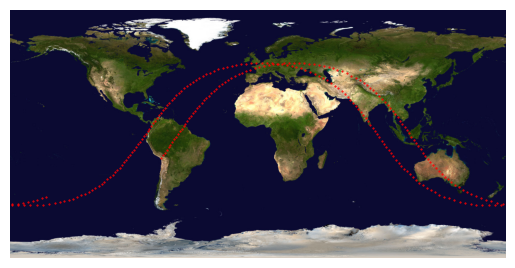

In [17]:
plt.imshow(Image.open("map.jpg"))

for i, row in df.iterrows():
    lat = df.at[i, "Latitude"] 
    lon = df.at[i, "Longitude"]

    plt.plot(
        (lon + 180) / 360 * 2048, # x
        (lat + 90) / 180 * 1024, # y
        marker='.', 
        color="red",
        markersize=1)

plt.axis('off')
plt.show()